# CIFAR10 image classification

### Import libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
from tensorflow.keras import datasets, layers, models
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Using TensorFlow backend.
/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Configure paths

In [2]:
LOCAL = 'True'
if LOCAL == 'True':
    path = '.'
else:
    from google.colab import drive
    drive.mount('/content/drive')
    path = './drive/My Drive/cifar'

### Download the CIFAR10 dataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

### Visualise the dataset

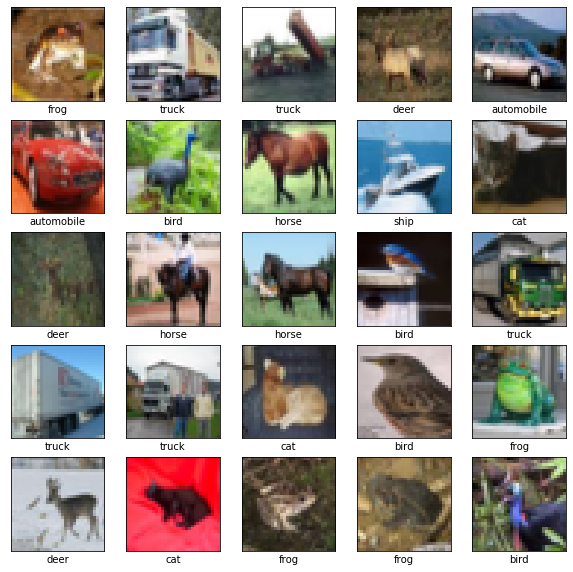

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels are arrays, 
    # which is why we need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Dimensionality Reduction

In [5]:
print('Training data and target sizes: \n{}, {}'.format(train_images.shape,train_labels.shape))
print('Test data and target sizes: \n{}, {}'.format(test_images.shape,test_labels.shape))

Training data and target sizes: 
(50000, 32, 32, 3), (50000, 1)
Test data and target sizes: 
(10000, 32, 32, 3), (10000, 1)


In [6]:
#Process the images to get an array

X_train = []
X_test = []
for img in train_images:
  img=(img.flatten())              
  X_train.append(np.array(img))
for img in test_images:
  img=(img.flatten())              
  X_test.append(np.array(img))
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.squeeze(train_labels[:50000, :])
y_test = np.squeeze(test_labels[:10000, :])

In [7]:
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(50000, 3072), (50000,)
Test data and target sizes: 
(10000, 3072), (10000,)


In [8]:
combined=np.vstack((X_train,X_test))

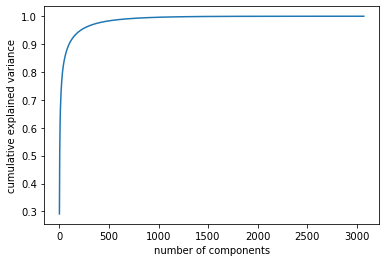

In [9]:
pca = PCA().fit(combined)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
for i in range(50,500,50):
  print(pca.explained_variance_ratio_.cumsum()[i])

In [9]:
pca = PCA(n_components=100)
pca.fit(combined)
projected = pca.transform(combined)
print(pca.explained_variance_.shape)
print(pca.components_.shape)
print(combined.shape)
print(projected.shape)

(100,)
(100, 3072)
(60000, 3072)
(60000, 100)


In [10]:
X_train_reduced=projected[:10000,:]# 50000 / 10000
y_train_reduced=y_train[:10000]# del / 10000
X_test_reduced=projected[50000:51000,:]# 50000:60000 / 50000:51000
y_test_reduced=y_test[:1000]# del / 1000
print(X_train_reduced.shape)
print(y_train_reduced.shape)
print(X_test_reduced.shape)
print(y_test_reduced.shape)

(10000, 100)
(10000,)
(1000, 100)
(1000,)


### Various Classifiers

### Random Forest

In [20]:
filename = os.path.join(path, 'rf-initial.sav')
if os.path.exists(filename):
    classifier = joblib.load(filename)
    run = 'False'
    print("model loaded successfully")
else:
    run = 'True'

model loaded successfully


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import GridSearchCV

if run == 'True':
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 100],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ["auto", "sqrt", "log2"],
    'n_estimators': [10],
    }

    rf = RandomForestClassifier(random_state = 42)
    CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5, verbose = 3, n_jobs = 6)
    CV_rf.fit(X_train, y_train)
    CV_rf.best_params_

In [25]:
y_pred = classifier.predict(X_test)
random_forest_score = accuracy_score(y_test, y_pred)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

if run == 'True':
    classifier = CV_rf.best_estimator_
    joblib.dump(classifier, filename)
    

print("Classification report for classifier:\n%f\n" % (random_forest_score))

Classification report for classifier:
0.398700



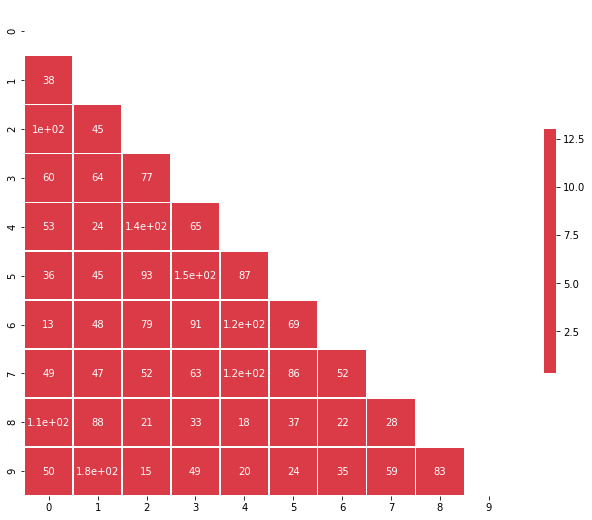

In [26]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(cm, range(len(cm)), range(len(cm)))
# Generate a mask for the upper triangle
mask = np.zeros_like(df_cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap = True)


# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(df_cm, mask = mask, annot = True, cmap = cmap, vmax = .3, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5})
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() 

In [29]:
filename = os.path.join(path, 'rf-reduced.sav')
if os.path.exists(filename):
    classifier = joblib.load(filename)
    run = 'False'
    print("model loaded successfully")
else:
    run = 'True'

model loaded successfully


In [30]:
if run == 'True':
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 100],
    'min_samples_leaf': [10, 20, 30, 50],
    'max_features': ["auto", "sqrt", "log2"],
    'n_estimators': [10],
    }

    rf = RandomForestClassifier(random_state = 42)
    CV_rf_red = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 3, verbose = 3, n_jobs = 6)
    CV_rf_red.fit(X_train_reduced, y_train_reduced)
    CV_rf_red.best_params_

In [32]:
y_pred = classifier.predict(X_test_reduced)
random_forest_score_reduced = accuracy_score(y_test_reduced, y_pred)

if run == 'True':
    joblib.dump(classifier, filename)
    classifier = CV_rf_red.best_estimator_

print("Classification report for classifier:\n%f\n" % (random_forest_score_reduced))

Classification report for classifier:
0.351000



### SGD classifier (SVM)

In [33]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="hinge", penalty="l2", max_iter=10000, random_state = 42, verbose = 0, n_jobs = 6)
sgd.fit(X_train_reduced, y_train_reduced)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=10000, n_iter_no_change=5, n_jobs=6, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
y_pred_sgd = sgd.predict(X_test_reduced)
sgd_score = accuracy_score(y_test_reduced, y_pred_sgd)
sgd_score

0.209

### KNN

In [35]:
filename = os.path.join(path, 'knn.sav')
if os.path.exists(filename):
    classifier = joblib.load(filename)
    run = 'False'
    print("model loaded successfully")
else:
    run = 'True'

model loaded successfully


In [36]:
if run =='True':

    from sklearn.neighbors import KNeighborsClassifier

    knn = KNeighborsClassifier()

    param_grid = {
    'leaf_size': [10, 20],
    'n_neighbors': [5, 10],
    }
    CV_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 3, verbose = 3, n_jobs = 6)
    CV_knn.fit(X_train_reduced, y_train_reduced)

    knn.fit(X_train_reduced, y_train_reduced)
    CV_knn.best_params_

In [38]:
y_pred = classifier.predict(X_test_reduced)
knn_score = accuracy_score(y_test_reduced, y_pred)

if run == 'True':
    joblib.dump(classifier, filename)
    classifier = CV_knn.best_estimator_
    
print("Classification report for classifier:\n%f\n" % (knn_score))

Classification report for classifier:
0.335000



### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 42)
lr.fit(X_train_reduced, y_train_reduced)

/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
y_pred = lr.predict(X_test_reduced)
logistic_regression_score = accuracy_score(y_test_reduced, y_pred)
logistic_regression_score

0.378

### SVM

In [42]:
from sklearn import svm
svc = svm.LinearSVC(verbose = 3, random_state = 42, max_iter = 10000)
svc.fit(X_train_reduced, y_train_reduced)

[LibLinear]

/home/reaper/anaconda3/envs/dl/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=3)

In [43]:
y_pred = svc.predict(X_test_reduced)
svc_score = accuracy_score(y_test_reduced, y_pred)
svc_score

0.2

In [44]:
print("RandomForestClassifier : ", random_forest_score)
print("RandomForestClassifier (reduced dataset) : ", random_forest_score_reduced)
print("SGD tClassifier : ", sgd_score)
print("K Nearest Neighbors : ", knn_score)
print("Logistic Regression : ", logistic_regression_score)
print("Support Vector Classifier : ", svc_score)

RandomForestClassifier :  0.3987
RandomForestClassifier (reduced dataset) :  0.351
SGD tClassifier :  0.209
K Nearest Neighbors :  0.335
Logistic Regression :  0.378
Support Vector Classifier :  0.2


### Dataset preparation for fully-fledged CNN

In [ ]:
# augment training set
datagen = tf.compat.v2.keras.preprocessing.image.ImageDataGenerator(rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    #vertical_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1)
for i in range(len(train_images)):
  augment = datagen.random_transform(x=train_images[i],seed=i)
  train_images[i]=augment

# Normalize pixel values to be between 0 and 1
  
train_images, test_images = train_images/255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels are arrays, 
    # which is why we need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Build the CNN model


In [ ]:
# Build the network of vgg for 10 classes with massive dropout and weight decay as described in this paper: https://arxiv.org/pdf/1409.1556.pdf.
num_classes = 10
weight_decay = 0.0005
x_shape = [32,32,3]

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
        
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
        
model.add(layers.MaxPooling2D((2, 2)))
        
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))
        
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
        
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(tf.compat.v2.keras.layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

### CNN model architecture


In [ ]:
model.summary()

### Training parameters and calbacks


In [ ]:
#training parameters
batch_size = 200
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

#optimization details
sgd = tf.compat.v2.keras.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

if os.path.exists(os.path.join(path,'cnn_weights.hdf5')):
  model.load_weights(os.path.join(path,'cnn_weights.hdf5'))
  maxepochs = 0
  print("weight loaded successfully")
elif os.path.exists(os.path.join(path,'cnn_cifar10.h5')):
  model.load_weights(os.path.join(path,'cnn_cifar10.h5'))
  maxepochs = 0
  print("model loaded successfully")
else: 
  print ("Nothing to upload")
  maxepochs = 150
    
#callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(path,'cnn_weights.hdf5'), verbose = 0, save_best_only = True)

def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

### Compile and train


In [ ]:
history = model.fit(train_images, train_labels,batch_size=batch_size, 
                            steps_per_epoch=len(train_images) // batch_size,
                            epochs=maxepochs, validation_steps = len(test_images)// batch_size,
                            validation_data=(test_images, test_labels),callbacks=[reduce_lr, checkpointer],verbose=2)

if maxepochs != 0:
    model.save_weights(os.path.join(path,'cnn_cifar10.h5'))

### Evaluation


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
model.load_weights(os.path.join(path,'cnn_weights.hdf5'))
print(test_acc)

### Dataset preparation for a ANN


In [56]:
# Let's use the dimensionality reduced dataset

X_train_ANN = projected[:50000,:]
y_train_ANN = y_train#.reshape(-1,1)
X_test_ANN = projected[50000:60000,:]
y_test_ANN = y_test#.reshape(-1,1)
print(X_train_ANN.shape)
print(y_train_ANN.shape)
print(X_test_ANN.shape)
print(y_test_ANN.shape)

(50000, 100)
(50000,)
(10000, 100)
(10000,)


In [57]:
# Feature Scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_ANN = sc.fit_transform(X_train_ANN)
X_test_ANN = sc.transform(X_test_ANN)

In [58]:
num_classes = 10
weight_decay = 0.0005 
batch_size = 200
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

In [68]:
ann = models.Sequential()

ann.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay), input_dim = X_train_ANN.shape[1]))
ann.add(layers.BatchNormalization())
ann.add(layers.Dropout(0.1))

ann.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
ann.add(layers.BatchNormalization())

ann.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
ann.add(layers.BatchNormalization())
ann.add(layers.Dropout(0.1))

ann.add(layers.Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
ann.add(layers.BatchNormalization())
ann.add(layers.Dropout(0.2))

ann.add(layers.Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
ann.add(layers.BatchNormalization())

ann.add(layers.Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
ann.add(layers.BatchNormalization())
ann.add(layers.Dropout(0.3))

ann.add(layers.Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
ann.add(layers.BatchNormalization())

ann.add(layers.Dense(512, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
ann.add(layers.BatchNormalization())
ann.add(layers.Dropout(0.4))

ann.add(layers.Dense(1024, activation = 'relu', kernel_regularizer=regularizers.l2(weight_decay)))
ann.add(layers.Dropout(0.5))

ann.add(layers.Dense(num_classes, activation = 'softmax'))

In [69]:
sgd = tf.compat.v2.keras.optimizers.SGD(lr=learning_rate, decay=lr_decay, momentum=0.9, nesterov=True)
ann.compile(loss='sparse_categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

In [70]:
ann.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               12928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)             

In [ ]:
# Fitting the ANN to the Training set
maxepochs = 50
ann_history = ann.fit(X_train_ANN, y_train_ANN,batch_size = batch_size, 
                            steps_per_epoch = X_train_ANN.shape[0] // batch_size,
                            epochs = maxepochs, validation_steps = X_test_ANN.shape[0] // batch_size,
                            validation_data=(X_test_ANN, y_test_ANN))#,callbacks=[reduce_lr, checkpointer],verbose=2)